dataset https://www.kaggle.com/c/digit-recognizer/data

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

seed = 69

torch.manual_seed(seed)
np.random.seed(seed)

In [32]:
class MnistDataset(Dataset):
    def __init__(self, csv_file, transform=None, train=True):
        '''
        Args:
            csv_file (string)
            transform (callable, optional)
        '''
        
        self.mnist = pd.read_csv(csv_file)
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if self.train:
            label = self.mnist.iloc[idx][0]
            label = np.array(label)

            img = self.mnist.iloc[idx].values[1:]
            img = img / 255 #normalize
            sample = {"label":label, "image":img}
            if self.transform:
                sample = self.transform(sample)
                
        else:
            img = self.mnist.iloc[idx].values
            img = img / 255
            sample = {"image": torch.from_numpy(img)}
            

            
        return sample

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)}

In [53]:
training_split = 0.8
batch_size = 32

mnist_train_dataset = MnistDataset("mnist/train.csv", transform=transforms.Compose([ToTensor()]))
mnist_test_dataset = MnistDataset("mnist/test.csv", train=False)

train_length = int(training_split * len(mnist_train_dataset))
validation_length = len(mnist_train_dataset) - train_length

train_dataset, validation_dataset = torch.utils.data.random_split(mnist_train_dataset, (train_length, validation_length))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test_dataset, batch_size=1, shuffle=False)

## Visualize images

<Figure size 432x288 with 0 Axes>

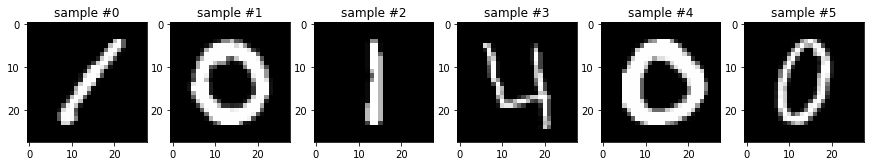

In [19]:
imgs_ = 6
fig = plt.figure()
plt.figure(figsize=(15,imgs_))
for i in range(imgs_):
    ax = plt.subplot(1, imgs_, i+1)
    ax.set_title('sample #{}'.format(i))
    plt.imshow(np.reshape(mnist_train_dataset[i]["image"], (28,28)), cmap='gray')
    
plt.show()

## create Model

In [20]:
learning_rate = 0.005
momentum = 0.5

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = MLP().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

# Define Train and Validation functions

In [27]:
def train(epoch, loader, log_interval=500):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, data in enumerate(train_loader):
        
        variables = data["image"].float().to(device)
        target = data["label"].to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(variables)
        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

def validate(loss, accuracy_list, loader):
    model.eval()
    val_loss, correct = 0, 0
    
    for data in loader:
        variables = data["image"].float().to(device)
        target = data["label"].to(device)
        
        
        output = model(variables)
        val_loss += criterion(output, target).data.item()
        
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(loader)
    loss.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(loader.dataset)
    accuracy_list.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset), accuracy))

# Training

In [28]:
epochs = 20

loss_, acc_ = [], []
for epoch in range(1, epochs + 1):
    train(epoch, train_loader)
    validate(loss_, acc_ , validation_loader)

Train Epoch: 1 [0/33600 (0%)]	Loss: 0.074902
Train Epoch: 1 [16000/33600 (48%)]	Loss: 0.157553
Train Epoch: 1 [32000/33600 (95%)]	Loss: 0.096836

Validation set: Average loss: 0.1467, Accuracy: 8011/8400 (95%)

Train Epoch: 2 [0/33600 (0%)]	Loss: 0.258070
Train Epoch: 2 [16000/33600 (48%)]	Loss: 0.099947
Train Epoch: 2 [32000/33600 (95%)]	Loss: 0.083451

Validation set: Average loss: 0.1416, Accuracy: 8048/8400 (96%)

Train Epoch: 3 [0/33600 (0%)]	Loss: 0.401501
Train Epoch: 3 [16000/33600 (48%)]	Loss: 0.134696
Train Epoch: 3 [32000/33600 (95%)]	Loss: 0.127010

Validation set: Average loss: 0.1431, Accuracy: 8023/8400 (96%)

Train Epoch: 4 [0/33600 (0%)]	Loss: 0.121020
Train Epoch: 4 [16000/33600 (48%)]	Loss: 0.047994
Train Epoch: 4 [32000/33600 (95%)]	Loss: 0.131753

Validation set: Average loss: 0.1372, Accuracy: 8041/8400 (96%)

Train Epoch: 5 [0/33600 (0%)]	Loss: 0.138590
Train Epoch: 5 [16000/33600 (48%)]	Loss: 0.160371
Train Epoch: 5 [32000/33600 (95%)]	Loss: 0.236159

Validation

# Running on test set

In [57]:
model.eval()
output_list = []
for idx, data in enumerate(test_loader):
    output = model(data["image"].float().to(device))
    output_list.append([idx+1, (output.data.max(1)[1].cpu().numpy().tolist()[0])])

In [62]:
len(output_list) == len(mnist_test_dataset)

True

In [61]:
#export to csv
pd.DataFrame(output_list, columns=["ImageId", "Label"]).to_csv("predictions_mlp.csv", index=False)